In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib
import os

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

In [2]:
print(tf.__version__)

2.9.0


In [3]:
data_dir = pathlib.Path(r"C:\Users\acynt\Desktop\weather-dataset")
print(data_dir)

C:\Users\acynt\Desktop\weather-dataset


In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

1122


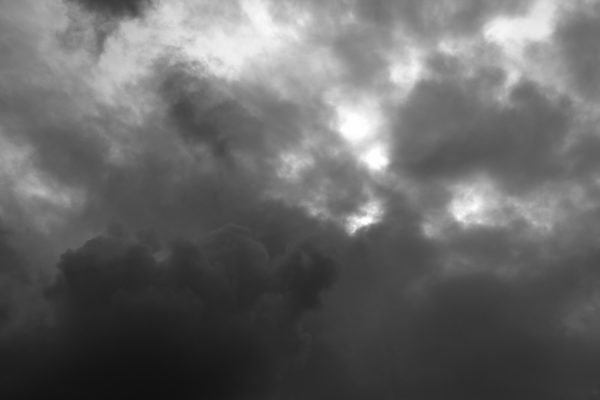

In [5]:
cloudy = list(data_dir.glob('cloudy/*'))
PIL.Image.open(str(cloudy[0]))

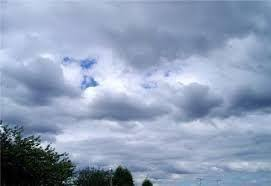

In [6]:
PIL.Image.open(str(cloudy[1]))

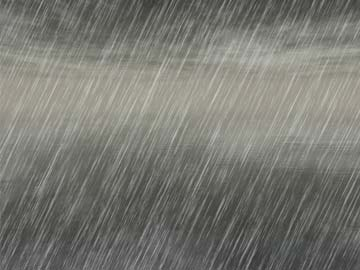

In [7]:
rain = list(data_dir.glob('rain/*'))
PIL.Image.open(str(rain[0]))

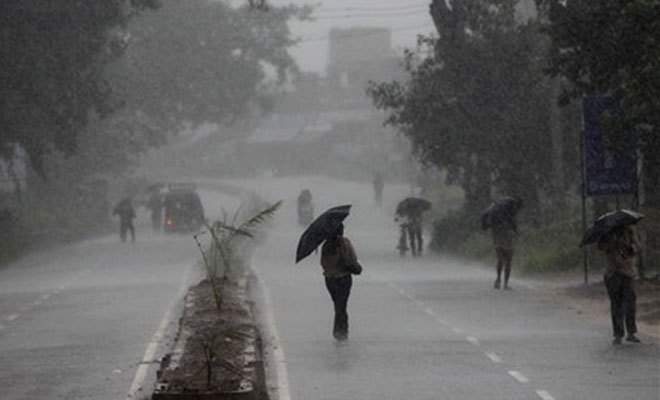

In [8]:
PIL.Image.open(str(rain[1]))

In [9]:
batch_size = 32
img_height = 180
img_width = 180

In [10]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1125 files belonging to 4 classes.
Using 900 files for training.


In [11]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1125 files belonging to 4 classes.
Using 225 files for validation.


In [12]:
class_names = train_ds.class_names
print(class_names)

['cloudy', 'rain', 'shine', 'sunrise']


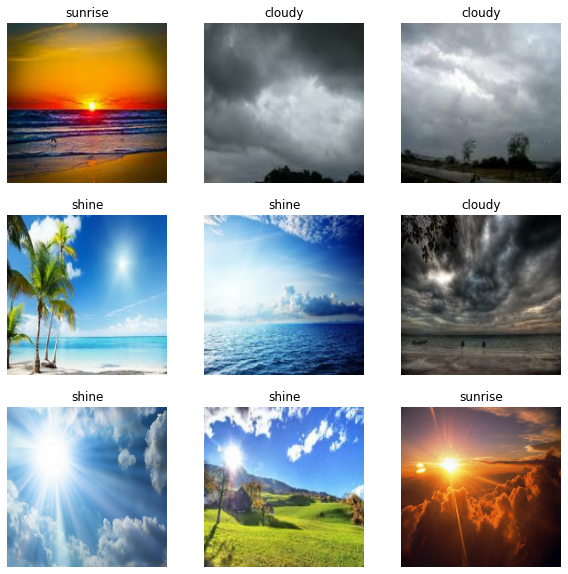

In [13]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [14]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [16]:
normalization_layer = layers.Rescaling(1./255)

In [17]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.06780136 1.0


In [18]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),  
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [21]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
29/29 [==============================] - 13s 45ms/step - loss: 0.7800 - accuracy: 0.7144 - val_loss: 0.4852 - val_accuracy: 0.8178
Epoch 2/10
29/29 [==============================] - 0s 17ms/step - loss: 0.4191 - accuracy: 0.8633 - val_loss: 0.4225 - val_accuracy: 0.8578
Epoch 3/10
29/29 [==============================] - 1s 22ms/step - loss: 0.3486 - accuracy: 0.8800 - val_loss: 0.4089 - val_accuracy: 0.8622
Epoch 4/10
29/29 [==============================] - 1s 20ms/step - loss: 0.2931 - accuracy: 0.8856 - val_loss: 0.5412 - val_accuracy: 0.8089
Epoch 5/10
29/29 [==============================] - 1s 18ms/step - loss: 0.2582 - accuracy: 0.9000 - val_loss: 0.3777 - val_accuracy: 0.8889
Epoch 6/10
29/29 [==============================] - 0s 17ms/step - loss: 0.1699 - accuracy: 0.9411 - val_loss: 0.4026 - val_accuracy: 0.8311
Epoch 7/10
29/29 [==============================] - 0s 17ms/step - loss: 0.1140 - accuracy: 0.9678 - val_loss: 0.3310 - val_accuracy: 0.8978
Epoch 8/10
2

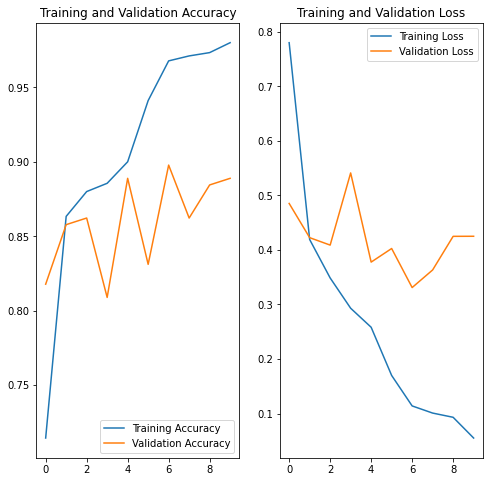

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [23]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

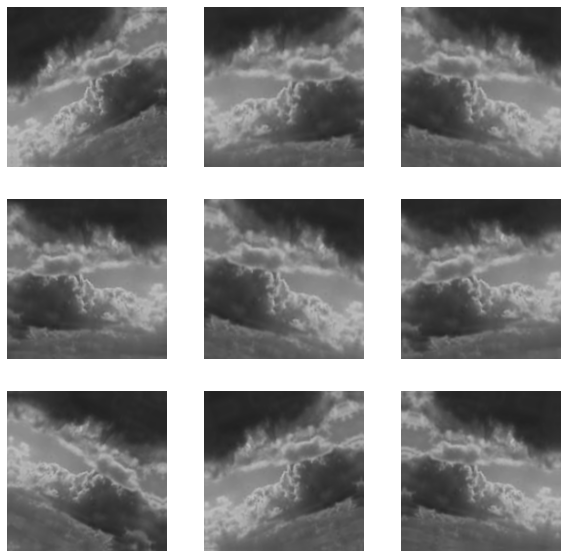

In [24]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [25]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [26]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [28]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
29/29 [==============================] - 3s 72ms/step - loss: 0.9226 - accuracy: 0.6156 - val_loss: 0.5741 - val_accuracy: 0.7600
Epoch 2/10
29/29 [==============================] - 2s 57ms/step - loss: 0.5456 - accuracy: 0.7856 - val_loss: 0.7414 - val_accuracy: 0.7511
Epoch 3/10
29/29 [==============================] - 1s 48ms/step - loss: 0.4391 - accuracy: 0.8256 - val_loss: 0.7136 - val_accuracy: 0.7644
Epoch 4/10
29/29 [==============================] - 2s 68ms/step - loss: 0.4096 - accuracy: 0.8600 - val_loss: 0.5317 - val_accuracy: 0.7956
Epoch 5/10
29/29 [==============================] - 2s 61ms/step - loss: 0.3554 - accuracy: 0.8644 - val_loss: 0.4950 - val_accuracy: 0.8089
Epoch 6/10
29/29 [==============================] - 1s 43ms/step - loss: 0.3389 - accuracy: 0.8633 - val_loss: 0.5605 - val_accuracy: 0.8044
Epoch 7/10
29/29 [==============================] - 2s 72ms/step - loss: 0.3393 - accuracy: 0.8622 - val_loss: 0.5176 - val_accuracy: 0.8000
Epoch 8/10
29

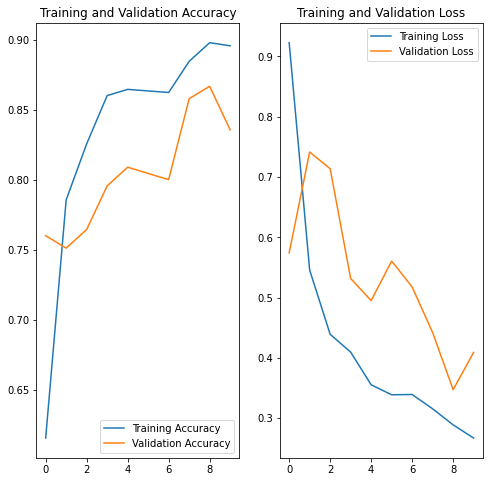

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [30]:
weather_url = "https://media.nationalgeographic.org/assets/photos/000/263/26383.jpg"
weather_path = tf.keras.utils.get_file('weather', origin=weather_url)

img = tf.keras.utils.load_img(
    weather_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print("Probabilities:")
print(score)

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 95ms/step
Probabilities:
tf.Tensor([7.0616072e-01 3.3543957e-03 4.8185579e-04 2.9000312e-01], shape=(4,), dtype=float32)
This image most likely belongs to cloudy with a 70.62 percent confidence.


In [31]:
weather2_url = "https://cff2.earth.com/uploads/2018/11/12235505/what-is-rain.jpg"
weather2_path = tf.keras.utils.get_file('weather2', origin=weather2_url)

img = tf.keras.utils.load_img(
    weather2_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print("Probabilities:")
print(score)

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 13ms/step
Probabilities:
tf.Tensor([0.00106832 0.97931117 0.00440746 0.01521302], shape=(4,), dtype=float32)
This image most likely belongs to rain with a 97.93 percent confidence.


In [32]:
weather3_url = "https://image.shutterstock.com/image-photo/beautiful-blue-sky-clouds-sun-260nw-1209009610.jpg"
weather3_path = tf.keras.utils.get_file('weather3', origin=weather3_url)

img = tf.keras.utils.load_img(
    weather3_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print("Probabilities:")
print(score)

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 15ms/step
Probabilities:
tf.Tensor([4.9828444e-02 7.7408843e-04 9.4911212e-01 2.8530700e-04], shape=(4,), dtype=float32)
This image most likely belongs to shine with a 94.91 percent confidence.


In [33]:
def predictNewImageUrl(image_url):
    
    image_path = tf.keras.utils.get_file('image_url', origin = image_url)
    
    os.remove(image_path)
    
    image_path = tf.keras.utils.get_file('image_url', origin = image_url)
    
    print(image_path)

    img = tf.keras.utils.load_img(
        image_path, target_size=(img_height, img_width)
    )
    
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    
    print("Probabilities:")
    print(score)

    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )

In [34]:
image_url = "https://image.shutterstock.com/image-photo/beautiful-blue-sky-clouds-sun-260nw-1209009610.jpg"

predictNewImageUrl(image_url)

23309/23309 [==============================] - 0s 1us/step
C:\Users\acynt\.keras\datasets\image_url
1/1 [==============================] - 0s 14ms/step
Probabilities:
tf.Tensor([4.9828444e-02 7.7408843e-04 9.4911212e-01 2.8530700e-04], shape=(4,), dtype=float32)
This image most likely belongs to shine with a 94.91 percent confidence.


In [35]:
def predictNewImageLocal(image_local):

    img = tf.keras.utils.load_img(
        image_local, target_size=(img_height, img_width)
    )
    
    print(image_local)
    
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    
    print("Probabilities:")
    print(score)

    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )

In [36]:
image_local = pathlib.Path(r"C:\Users\acynt\Desktop\weather-dataset\cloudy\cloudy1.jpg")

predictNewImageLocal(image_local)

C:\Users\acynt\Desktop\weather-dataset\cloudy\cloudy1.jpg
1/1 [==============================] - 0s 17ms/step
Probabilities:
tf.Tensor([8.1332576e-01 1.8547222e-01 1.0562547e-03 1.4570331e-04], shape=(4,), dtype=float32)
This image most likely belongs to cloudy with a 81.33 percent confidence.


In [37]:
!mkdir saved_model
model.save('saved_model/weather_cnn')
print("Finished saving model...")

A subdirectory or file saved_model already exists.


INFO:tensorflow:Assets written to: saved_model/weather_cnn\assets


INFO:tensorflow:Assets written to: saved_model/weather_cnn\assets


Finished saving model...


In [38]:
new_model = tf.keras.models.load_model('saved_model/weather_cnn')

# Check its architecture
new_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [39]:
def predictNewImageUrlSavedModel(image_url):
    
    image_path = tf.keras.utils.get_file('image_url', origin = image_url)
    
    os.remove(image_path)
    
    image_path = tf.keras.utils.get_file('image_url', origin = image_url)
    
    print(image_path)

    img = tf.keras.utils.load_img(
        image_path, target_size=(img_height, img_width)
    )
    
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = new_model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    
    print("Probabilities:")
    print(score)

    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )

In [40]:
image_url = "https://image.shutterstock.com/image-photo/beautiful-blue-sky-clouds-sun-260nw-1209009610.jpg"

predictNewImageUrlSavedModel(image_url)

23309/23309 [==============================] - 0s 2us/step
C:\Users\acynt\.keras\datasets\image_url
1/1 [==============================] - 0s 59ms/step
Probabilities:
tf.Tensor([4.9828444e-02 7.7408843e-04 9.4911212e-01 2.8530700e-04], shape=(4,), dtype=float32)
This image most likely belongs to shine with a 94.91 percent confidence.


In [41]:
!mkdir saved_model
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save('saved_model/weather_cnn.h5')
print("Finished saving model...")

Finished saving model...


A subdirectory or file saved_model already exists.


In [42]:
# Recreate the exact same model, including its weights and the optimizer
new_model_h5 = tf.keras.models.load_model('saved_model/weather_cnn.h5')

# Show the model architecture
new_model_h5.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [43]:
def predictNewImageUrlSavedModelH5(image_url):
    
    image_path = tf.keras.utils.get_file('image_url', origin = image_url)
    
    os.remove(image_path)
    
    image_path = tf.keras.utils.get_file('image_url', origin = image_url)
    
    print(image_path)

    img = tf.keras.utils.load_img(
        image_path, target_size=(img_height, img_width)
    )
    
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = new_model_h5.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    
    print("Probabilities:")
    print(score)

    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )

In [44]:
image_url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcStQijbfj3LAVZtiu5awvRuBJWteQCQYLIMX4JeTJPuyyO8y4u2-qUJUqqpyQ3XLr6_h70&usqp=CAU"

predictNewImageUrlSavedModelH5(image_url)

9562/9562 [==============================] - 0s 0us/step
C:\Users\acynt\.keras\datasets\image_url
1/1 [==============================] - 0s 58ms/step
Probabilities:
tf.Tensor([6.0616987e-04 9.9881929e-01 5.3926470e-04 3.5230045e-05], shape=(4,), dtype=float32)
This image most likely belongs to rain with a 99.88 percent confidence.


In [45]:
resnet_model = Sequential()

pretrained_model = tf.keras.applications.ResNet50V2(include_top=False,
                                                  input_shape=(180,180,3),
                                                  pooling='avg',
                                                  classes=4,
                                                  weights='imagenet')

for layer in pretrained_model.layers:
    layer.trainable=False

resnet_model.add(data_augmentation)
resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(4, activation='softmax'))

resnet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               1049088   
                                                                 
 dense_5 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 24,615,940
Trainable params: 1,051,140
Non-trainable params: 23,564,800
_________________________________________________________________


In [46]:
resnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                     metrics=['accuracy'])

In [47]:
epochs = 10
resnet_model_history = resnet_model.fit(train_ds,
                                        validation_data=val_ds,
                                        epochs=epochs)

Epoch 1/10


C:\Users\acynt\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


29/29 [==============================] - 8s 143ms/step - loss: 76.6783 - accuracy: 0.6133 - val_loss: 23.4808 - val_accuracy: 0.7333
Epoch 2/10
29/29 [==============================] - 3s 88ms/step - loss: 9.1552 - accuracy: 0.8167 - val_loss: 14.9026 - val_accuracy: 0.8400
Epoch 3/10
29/29 [==============================] - 3s 89ms/step - loss: 7.6637 - accuracy: 0.8322 - val_loss: 10.9984 - val_accuracy: 0.8489
Epoch 4/10
29/29 [==============================] - 3s 96ms/step - loss: 4.5905 - accuracy: 0.8511 - val_loss: 7.4990 - val_accuracy: 0.8444
Epoch 5/10
29/29 [==============================] - 3s 116ms/step - loss: 5.8926 - accuracy: 0.8200 - val_loss: 5.0855 - val_accuracy: 0.8711
Epoch 6/10
29/29 [==============================] - 3s 89ms/step - loss: 5.0958 - accuracy: 0.8589 - val_loss: 10.4222 - val_accuracy: 0.8044
Epoch 7/10
29/29 [==============================] - 2s 71ms/step - loss: 5.4729 - accuracy: 0.8433 - val_loss: 7.7578 - val_accuracy: 0.8222
Epoch 8/10
29/29 

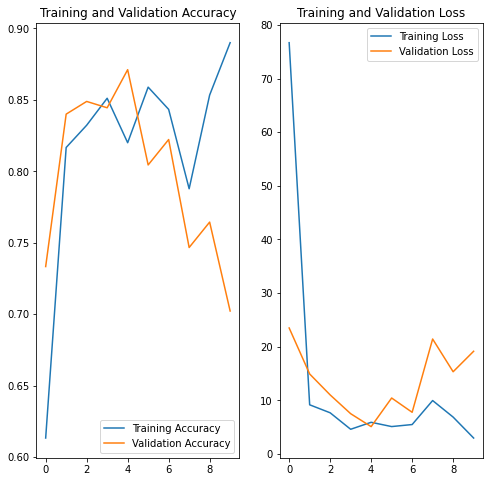

In [48]:
acc = resnet_model_history.history['accuracy']
val_acc = resnet_model_history.history['val_accuracy']

loss = resnet_model_history.history['loss']
val_loss = resnet_model_history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [49]:
def predictNewImageUrlResnet(image_url):
    
    image_path = tf.keras.utils.get_file('image_url', origin = image_url)
    
    os.remove(image_path)
    
    image_path = tf.keras.utils.get_file('image_url', origin = image_url)
    
    print(image_path)

    img = tf.keras.utils.load_img(
        image_path, target_size=(img_height, img_width)
    )
    
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = resnet_model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    
    print("Probabilities:")
    print(score)

    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )

In [50]:
image_url = "https://cff2.earth.com/uploads/2018/11/12235505/what-is-rain.jpg"

predictNewImageUrlResnet(image_url)

284366/284366 [==============================] - 1s 2us/step
C:\Users\acynt\.keras\datasets\image_url
1/1 [==============================] - 1s 704ms/step
Probabilities:
tf.Tensor([0.17487772 0.47536686 0.17487772 0.17487772], shape=(4,), dtype=float32)
This image most likely belongs to rain with a 47.54 percent confidence.
